In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import datetime
from matplotlib import pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from time import perf_counter

from tst import Transformer
from tst.transformer import Transformer_Original
from tst.loss import OZELoss
import os
import pandas as pd
import torch.nn as nn

from src.dataset import OzeDataset
from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample
# sns.set()

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

In [2]:
path = '/share/data/willett-group/'


us_mask = pd.DataFrame(pd.read_hdf(path + 'us_mask.h5'))
# us_mask = pd.DataFrame(pd.read_hdf('~/Desktop/Research/data/SSF/us_mask.h5'))
# This block is to put all nearby sst data together in time order
# And also transform data into time order (single location\)
y_samp = pd.Series()
X_total = []
for i in range(2014,2019):
    print('precip.'+str(i)+'.h5')
    name_precip = 'precip.'+str(i)+'.h5'
    name_sst = 'sst.'+str(i)+'.h5' 
    name_hgt = 'hgt500.'+str(i)+'.h5'
    name_rhum = 'rhum.sig995.'+str(i)+'.h5'
    name_tmp2m = 'tmp2m.'+str(i)+'.h5'
    fileloc_precip = path + name_precip
    fileloc_sst = path + name_sst
    fileloc_hgt = path + name_hgt
    fileloc_rhum = path + name_rhum
    fileloc_tmp2m = path + name_tmp2m
    precip = pd.DataFrame(pd.read_hdf(fileloc_precip)).reset_index()
    precip.columns = ['lat', 'lon', 'start_date', 'precip']
    sst = pd.DataFrame(pd.read_hdf(fileloc_sst)).reset_index()
    sst.columns = ['lat', 'lon', 'start_date', 'sst']
    hgt = pd.DataFrame(pd.read_hdf(fileloc_hgt)).reset_index()
    hgt.columns = ['lat', 'lon', 'start_date', 'hgt']
    rhum = pd.DataFrame(pd.read_hdf(fileloc_rhum)).reset_index()
    rhum.columns = ['lat', 'lon', 'start_date', 'rhum']
    tmp2m = pd.DataFrame(pd.read_hdf(fileloc_tmp2m)).reset_index()
    tmp2m.columns = ['lat', 'lon', 'start_date', 'tmp2m']
    
    precip = pd.merge(precip, us_mask, on=['lat','lon'])
    hgt = pd.merge(hgt, us_mask, on=['lat','lon'])
    rhum = pd.merge(rhum, us_mask, on=['lat','lon'])
    tmp2m = pd.merge(tmp2m, us_mask, on=['lat','lon'])
    
    hgt = np.reshape(hgt[(hgt['lat']==25.25) & (hgt['lon']==279.25)].hgt.to_numpy(),(-1,1))
    rhum = np.reshape(rhum[(rhum['lat']==25.25) & (rhum['lon']==279.25)].rhum.to_numpy(),(-1,1))
    precip = np.reshape(precip[(precip['lat']==25.25) & (precip['lon']==279.25)].precip.to_numpy(),(-1,1))
    
    y_samp = y_samp.append(tmp2m[tmp2m['lat']==25.25].tmp2m,ignore_index=True)
    
    if i%4 == 0:
        days = 366
    else:
        days = 365
    temp = sst[(sst['lat']>=24.25) & (sst['lat']<=26.25) & (sst['lon']>=278.25) & (sst['lon']<=280.25)]
    sst_samp = temp.sst.reset_index().sst.to_numpy()
    size = int(len(sst_samp)/days)
    sst_samp = np.reshape(sst_samp,(size,days)).transpose() # days as rows, different locations as columns
    all_features = np.concatenate((sst_samp,hgt,rhum,precip),axis=1)
    X_total.append(all_features)
    
X_size = X_total[0].shape[1]
X_samp = np.zeros((1,X_size)) #  For concatenating all data
for i in range(len(X_total)):
    X_samp = np.concatenate((X_samp,X_total[i]),axis = 0)
X_samp = X_samp[1:]

<ipython-input-2-00ed06899b02>:8: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  y_samp = pd.Series()


precip.2014.h5
precip.2015.h5
precip.2016.h5
precip.2017.h5
precip.2018.h5


In [3]:
X_copy = X_samp.copy()
y_copy = y_samp.to_numpy().copy()

In [4]:
X_samp = X_copy.copy()
y_samp = y_copy.copy()
target = 'tmp2m'

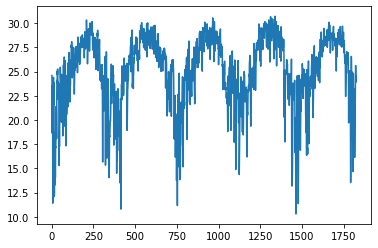

In [5]:
plt.plot(y_samp)

In [6]:
# Calculate moving average for precip
avg_window = 14
y_movavg = []
X_movavg = []
for i in range(y_samp.shape[0]-avg_window):
    y_avg = np.mean(y_samp[i:i+avg_window])
    y_movavg.append(y_avg)
    X_avg = np.mean(X_samp[i:i+avg_window],axis=0)
    X_movavg.append(X_avg)
y_movavg = np.array(y_movavg)
X_movavg = np.array(X_movavg)
y_samp = y_movavg
X_samp = X_movavg

In [7]:
# Standardize data by z-scoring
# mean = np.mean(y_samp)
# std = np.std(y_samp)
# y_samp = (y_samp-mean)/std
# X_samp[:,0:16] = (X_samp[:,0:16] - np.mean(X_samp[:,0:16]))/np.std(X_samp[:,16])
# X_samp[:,16] = (X_samp[:,16] - np.mean(X_samp[:,16]))/np.std(X_samp[:,16])
# X_samp[:,17] = (X_samp[:,17] - np.mean(X_samp[:,17]))/np.std(X_samp[:,17])
# X_samp[:,18] = (X_samp[:,18] - np.mean(X_samp[:,18]))/np.std(X_samp[:,18])

# X = X_samp.copy()
# y = y_samp.copy()




In [7]:
M = np.max(y_samp)
m = np.min(y_samp)
y_samp = (y_samp -m)/(M - m)
X_samp[:,0:16] = (X_samp[:,0:16] - np.min(X_samp[:,0:16]))/ (np.max(X_samp[:,0:16]) - np.min(X_samp[:,0:16]))
X_samp[:,16] = (X_samp[:,16] - np.min(X_samp[:,16]))/(np.max(X_samp[:,16]) - np.min(X_samp[:,16]))
X_samp[:,17] = (X_samp[:,17] - np.min(X_samp[:,17]))/(np.max(X_samp[:,17]) - np.min(X_samp[:,17]))
X_samp[:,18] = (X_samp[:,18] - np.min(X_samp[:,18]))/(np.max(X_samp[:,18]) - np.min(X_samp[:,18]))

X = X_samp.copy()
y = y_samp.copy()

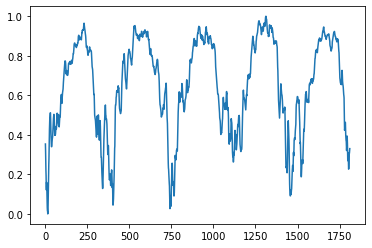

In [8]:
plt.plot(y_samp)

In [9]:
print(X.shape)
print(y.shape)

(1812, 19)
(1812,)


In [10]:
train_test_split = 0.8
test_size = int((1-train_test_split)*y_samp.shape[0])
X_train = X[:-test_size]
X_test = X[-test_size:]
y_train = y[:-test_size]
y_test = y[-test_size:]

In [11]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, 

((1450, 19), (1450,), (362, 19), (362,))

In [12]:
# Create dataset by using the sliding window approach
# Input/Output pairs = (X_{t-iw+1:t}, y_{t+1:t+ow})
# Transformer takes same sequence length, so we have three approaches: (Assume iw > ow)
# 1. Use X_{t-iw:t} and [y_{t:t+ow}, 0,...,0]
# 2. Use X_{t-iw:t} and y_{t-(iw-ow):t+ow}
# 3. Use X_{t-iw:t} and t_{t:t+iw}
def create_sequence_padding(X,y, input_window,output_window): 
    L = X.shape[0]
    num_features = X.shape[1]
    X_samples = torch.zeros(L-input_window-output_window,input_window,num_features)
#     print(X_samples.shape)
    y_samples = torch.zeros(L-input_window-output_window,input_window,1)
#     print(y_samples.shape)
    for i in range(L-input_window-output_window):
        # Note that i goes from 0 to T - iw - ow, but our sample points are at t from iw - 1 to T - ow - 1
        # i.e. at each time point, t = i + iw - 1
        X_seq = X[i:i+input_window,:] # t - iw + 1 to t
        y_seq = y[i+input_window:i+input_window+output_window]
        y_seq = np.pad(y_seq,(0,input_window-output_window))
#         print(X_seq.shape)
#         print(y_seq.shape)
#         print(y_samples[i,:,:].shape)
        X_samples[i,:,:] = torch.from_numpy(X_seq)
        y_samples[i,:,0] = torch.from_numpy(y_seq)
    return X_samples, y_samples

In [106]:
X_samples_train, y_samples_train = create_sequence_padding(X_train, y_train, 30, 14)

print(X_samples_train.shape)
print(y_samples_train.shape)

torch.Size([1406, 30, 19])
torch.Size([1406, 30, 1])


In [107]:
X_samples_train[0].shape

torch.Size([30, 19])

In [108]:
y_samples_train[0][13]

tensor([0.3932])

In [42]:
# Approach 2
def create_sequence_shifting(X,y, input_window,output_window): 
    L = X.shape[0]
    num_features = X.shape[1]
    X_samples = torch.zeros(L-input_window-output_window,input_window,num_features)
#     print(X_samples.shape)
    y_samples = torch.zeros(L-input_window-output_window,input_window,1)
#     print(y_samples.shape)
    for i in range(L-input_window-output_window):
        # Note that i goes from 0 to T - iw - ow, but our sample points are at t from iw - 1 to T - ow - 1
        # i.e. at each time point, t = i + iw - 1
        X_seq = X[i:i+input_window,:] # t - iw + 1 to t
        y_seq = y[i+output_window:i+input_window+output_window]      
#         print(X_seq.shape)
#         print(y_seq.shape)
#         print(y_samples[i,:,:].shape)
        X_samples[i,:,:] = torch.from_numpy(X_seq)
        y_samples[i,:,0] = torch.from_numpy(y_seq)
    return X_samples,y_samples

# X_samples, y_samples = create_sequence_shifting(X_train, y_train, 30, 14)
# print(X_samples.shape)
# print(y_samples.shape)

In [46]:
X_samples_train, y_samples_train = create_sequence_shifting(X_train, y_train, 30, 14)

print(X_samples_train.shape)
print(y_samples_train.shape)

torch.Size([1406, 30, 19])
torch.Size([1406, 30, 1])


In [48]:
y_samples_train[0][-1]

tensor([0.3932])

In [85]:
# Approach 3
def create_sequence_matching(X,y, input_window): 
    L = X.shape[0]
    num_features = X.shape[1]
    X_samples = torch.zeros(L-2*input_window,input_window,num_features)
#     print(X_samples.shape)
    y_samples = torch.zeros(L-2*input_window,input_window,1)
#     print(y_samples.shape)
    for i in range(L-2*input_window):
        # Note that i goes from 0 to T - iw - ow, but our sample points are at t from iw - 1 to T - ow - 1
        # i.e. at each time point, t = i + iw - 1
        X_seq = X[i:i+input_window,:] # t - iw + 1 to t
        y_seq = y[i+input_window:i+2*input_window]      
#         print(X_seq.shape)
#         print(y_seq.shape)
#         print(y_samples[i,:,:].shape)
        X_samples[i,:,:] = torch.from_numpy(X_seq)
        y_samples[i,:,0] = torch.from_numpy(y_seq)
    return X_samples,y_samples

# X_samples, y_samples = create_sequence_matching(X,y,30)
# print(X_samples.shape)
# print(y_samples.shape)

In [86]:
X_samples_train, y_samples_train = create_sequence_matching(X_train, y_train, 30)

print(X_samples_train.shape)
print(y_samples_train.shape)

torch.Size([1390, 30, 19])
torch.Size([1390, 30, 1])


In [87]:
y_samples_train[0][13]

tensor([0.3932])

In [14]:
import datetime

import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
import seaborn as sns

from tst import Transformer
from tst.loss import OZELoss
import os

from src.dataset import OzeDataset
from src.utils import compute_loss
from src.visualization import map_plot_function, plot_values_distribution, plot_error_distribution, plot_errors_threshold, plot_visual_sample

In [18]:
BATCH_SIZE = 16
NUM_WORKERS = 0
LR = 1e-4
EPOCHS = 30

# Model parameters
d_model = 64 # Lattent dim
q = 8 # Query size
v = 8 # Value size
h = 8 # Number of heads
N = 4 # Number of encoder and decoder to stack
attention_size = 10 # Attention window size
dropout = 0.2 # Dropout rate
pe = None # Positional encoding
chunk_mode = None

d_input = 19 # From dataset
d_output = 1 # From dataset


In [109]:
from torch.utils.data import Dataset, DataLoader

class SeqDataset(Dataset):
    def __init__(self, X, y, transform=None):
        
#         self.seq_data = seq_data
        self.x = X
        self.y = y
#         for i in range(len(self.seq_data)):
#             self.x.append(self.seq_data[i][0])
#             self.y.append(self.seq_data[i][1])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return (self.x[idx], self.y[idx])

    def __len__(self):
        return len(self.x) #self._x.shape[0]

In [110]:
dataset_train = SeqDataset(X_samples_train, y_samples_train)
dataloader_train = DataLoader(dataset_train,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [111]:
len(dataloader_train)

88

In [24]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '4'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [128]:
d_input = 19 # From dataset
d_output = 1 # From dataset
attention_size = 12
LR = 1e-4 #1e-3
net = Transformer_Original(d_input, d_model, d_output, q, v, h, N, attention_size=attention_size, 
                  dropout=dropout, chunk_mode=chunk_mode, pe=pe).to(device)

optimizer = optim.Adam(net.parameters(), lr=LR)
loss_function = nn.MSELoss() #OZELoss(alpha=0.3)

In [51]:
len(X_samples)

1768

[Epoch  40/40]: 100%|██████████| 1406/1406 [00:11<00:00, 124.85it/s, loss=0.0125]


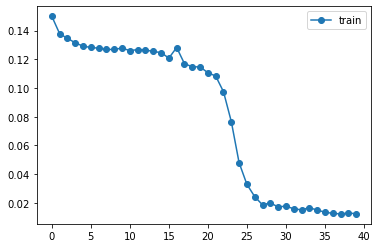

In [129]:
EPOCHS = 40
hist_loss = np.zeros(EPOCHS)
hist_loss_val = np.zeros(EPOCHS)

for idx_epoch in range(EPOCHS):
    running_loss = 0
    with tqdm(total=len(X_samples_train), desc=f"[Epoch {idx_epoch+1:3d}/{EPOCHS}]") as pbar:
        for idx_batch, (x, y) in enumerate(dataloader_train):
#             x = x.unsqueeze(0)
#             y = y.view(-1,1)
            optimizer.zero_grad()

            # Propagate input
            netout = net(x.to(device))

            # Compute loss
#             print(netout, y)
            loss = loss_function(y.to(device), netout)

            # Backpropage loss
            loss.backward()

            # Update weights
            optimizer.step()

            running_loss += loss.item()
            pbar.set_postfix({'loss': running_loss/(idx_batch+1)})
            pbar.update(x.shape[0])
                
            
        train_loss = running_loss/len(dataloader_train)
#         print('pred, target', netout, y)
#         val_loss = compute_loss(net, dataloader_val, loss_function, device).item()
#         pbar.set_postfix({'loss': train_loss, 'val_loss': val_loss})
        pbar.set_postfix({'loss': train_loss})

        hist_loss[idx_epoch] = train_loss
#         hist_loss_val[idx_epoch] = val_loss

#         if val_loss < val_loss_best:
#             val_loss_best = val_loss
#             torch.save(net.state_dict(), model_save_path)
        
plt.plot(hist_loss, 'o-', label='train')
# plt.plot(hist_loss_val, 'o-', label='val')
plt.legend()
# print(f"model exported to {model_save_path} with loss {val_loss_best:5f}")

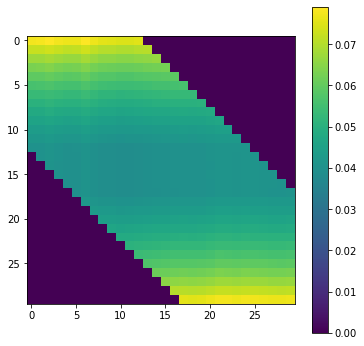

In [130]:
# Select first encoding layer
encoder = net.layers_encoding[0]

# Get the first attention map
attn_map = encoder.attention_map[0].cpu().detach().numpy()
# Plot
plt.figure(figsize=(6, 6))
plt.imshow(attn_map)
plt.colorbar();
# plt.savefig("attention_map")

In [131]:
net.eval();

In [93]:
X_samples_test, y_samples_test = create_sequence_matching(X_test, y_test, 30)

print(X_samples_test.shape)
print(y_samples_test.shape)

torch.Size([302, 30, 19])
torch.Size([302, 30, 1])


In [132]:
X_samples_test, y_samples_test = create_sequence_padding(X_test, y_test, 30, 14)

print(X_samples_test.shape)
print(y_samples_test.shape)

torch.Size([318, 30, 19])
torch.Size([318, 30, 1])


In [69]:
X_samples_test, y_samples_test = create_sequence_shifting(X_test, y_test, 30, 14)

print(X_samples_test.shape)
print(y_samples_test.shape)

torch.Size([318, 30, 19])
torch.Size([318, 30, 1])


In [133]:
dataset_test = SeqDataset(X_samples_test, y_samples_test)
dataloader_test = DataLoader(dataset_test,
                              batch_size=1,
                              shuffle=False,
                              num_workers=0,
                              pin_memory=False
                             )

In [84]:
# dataloader_train = DataLoader(dataset_train,
#                               batch_size=1,
#                               shuffle=False,
#                               num_workers=0,
#                               pin_memory=False
#                              )

In [134]:
res_train = []
for x, y in tqdm(dataloader_train):
    for j in range(num_pred):
        x = x.to(device)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(x).cpu()
            #print(len(test_inputs))
            for i in range(len(pred)):
                res_train.append(pred[i][13][0])
            
res_train = np.array(res_train)

100%|██████████| 88/88 [00:01<00:00, 63.25it/s]


In [135]:
res_train.shape

(1406,)

In [136]:
# Predicting t+1

net.eval()
num_pred = 1
# num_pred = 1 #  Number of prediction forward, i.e. tau
# res = np.zeros(train_window).tolist()
#  Predicting y using X_test and y_test
res = []
for x, y in tqdm(dataloader_test):
    for j in range(num_pred):
        x = x.to(device)
        #print(seq)
        with torch.no_grad():
            #print(model(seq))
            pred = net(x).cpu()
            #print(len(test_inputs))
            res.append(pred[0][13][0])
res = np.array(res)


100%|██████████| 318/318 [00:04<00:00, 69.66it/s]


In [104]:
# res

In [120]:
res.shape

(318,)

In [137]:
target = []
for i in range(len(y_samples_test)):
    target.append(y_samples_test[i][13])

In [138]:
target_train = []
for i in range(len(y_samples_train)):
    target_train.append(y_samples_train[i][13])

In [139]:
len(target_train)

1406

r-sq on train: 0.7137056444364991
r-sq on test: 0.505012690682304


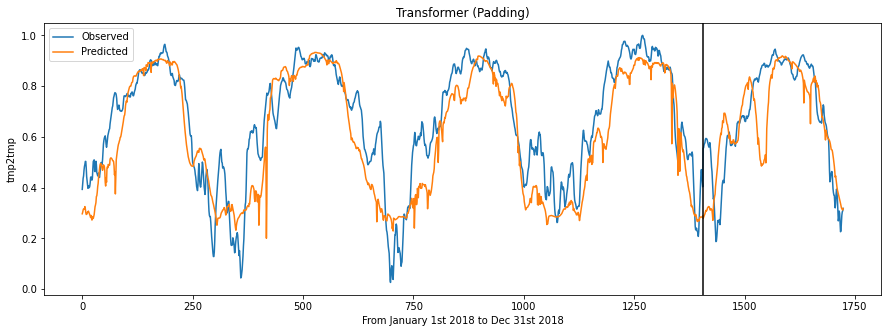

In [140]:
print('r-sq on train:', r2_score(target_train, res_train))
print('r-sq on test:', r2_score(target, res))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((target_train, target)),label='Observed')
plt.plot(np.concatenate((res_train, res)),label='Predicted')
plt.axvline(x=len(target_train), c='black')
plt.legend()
plt.xlabel('From January 1st 2018 to Dec 31st 2018')
plt.ylabel('tmp2tmp')
plt.title('Transformer (Padding)');
# plt.savefig('plot_transform_match.pdf')

r-sq on train: -0.001206125673518077
r-sq on test: -0.011321435164519444


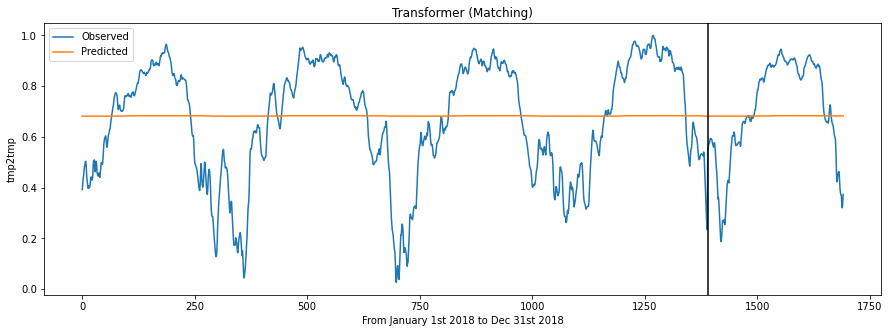

In [105]:
print('r-sq on train:', r2_score(target_train, res_train))
print('r-sq on test:', r2_score(target, res))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((target_train, target)),label='Observed')
plt.plot(np.concatenate((res_train, res)),label='Predicted')
plt.axvline(x=len(target_train), c='black')
plt.legend()
plt.xlabel('From January 1st 2018 to Dec 31st 2018')
plt.ylabel('tmp2tmp')
plt.title('Transformer (Matching)');
# plt.savefig('plot_transform_match.pdf')

r-sq on train: 0.5749919539141384
r-sq on test: 0.057557023755569814


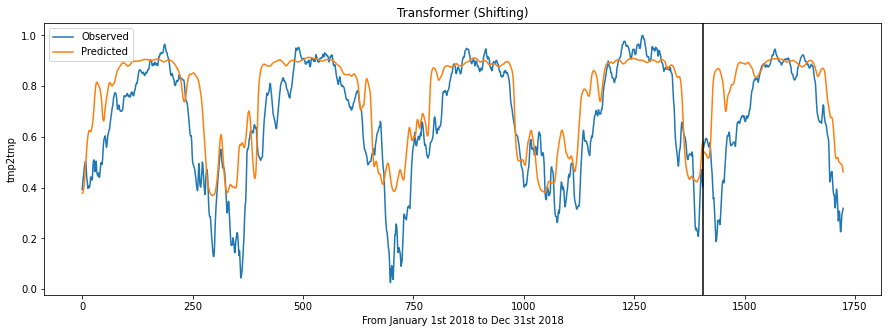

In [82]:
print('r-sq on train:', r2_score(target_train, res_train))
print('r-sq on test:', r2_score(target, res))
plt.figure(figsize=(15,5))
plt.plot(np.concatenate((target_train, target)),label='Observed')
plt.plot(np.concatenate((res_train, res)),label='Predicted')
plt.axvline(x=len(target_train), c='black')
plt.legend()
plt.xlabel('From January 1st 2018 to Dec 31st 2018')
plt.ylabel('tmp2tmp')
plt.title('Transformer (Shifting)');
plt.savefig('plot_transform_shifting_1.pdf')

In [99]:
np.concatenate((res_train, res))

array([0.35694528, 0.35672885, 0.3567776 , ..., 0.28520048, 0.284749  ,
       0.28429332], dtype=float32)

In [97]:
res_train

array([0.35694528, 0.35672885, 0.3567776 , ..., 0.28520048, 0.284749  ,
       0.28429332], dtype=float32)

In [98]:
res

array([0.42203546, 0.43119228, 0.44084275, 0.45110732, 0.46201223,
       0.47377345, 0.48674393, 0.5014236 , 0.517829  , 0.5343007 ,
       0.5473378 , 0.55426866, 0.55524945, 0.5516604 , 0.5439016 ,
       0.53205115, 0.51913923, 0.50713336, 0.49597308, 0.4854154 ,
       0.47516885, 0.465531  , 0.4565496 , 0.44779882, 0.43889514,
       0.42959625, 0.41975084, 0.40911728, 0.39757872, 0.38503838,
       0.37119952, 0.35549623, 0.33973363, 0.32916442, 0.32800937,
       0.33810967, 0.35278645, 0.3688553 , 0.38287824, 0.39475572,
       0.40524644, 0.4147561 , 0.42365864, 0.43228737, 0.44097105,
       0.4502506 , 0.4602213 , 0.47141758, 0.4838403 , 0.49692836,
       0.5102227 , 0.52351195, 0.5369426 , 0.5509902 , 0.5629978 ,
       0.57002527, 0.5711722 , 0.5687624 , 0.56492734, 0.5601283 ,
       0.5548683 , 0.54878706, 0.54345024, 0.5387585 , 0.53514254,
       0.532139  , 0.5291267 , 0.52560276, 0.52206945, 0.5185594 ,
       0.51585436, 0.5139588 , 0.5125217 , 0.5108997 , 0.51057